In [5]:
import json
from random import sample
from collections import defaultdict
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.feature_selection import f_classif, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Read in data

In [6]:
def read_in_data(threshold=0.001, window=5, drop_lags=True, drop_2020=True):
    """
    Takes in an ITM threshold and window (1, 5, 10, 21, reads in and returns data clean.)
    """
    badf = pd.read_csv('data/badf.csv', index_col=0, parse_dates=True)
    badf.drop(columns = ['open', 'high', 'low', 'close'], inplace=True)

    badf['label'] = (badf[f'target_{window}d']>threshold).astype(int)
    badf = badf.drop(columns = ['target_1d','target_5d','target_10d','target_21d'])
    badf = badf.drop(columns = [column for column in badf.columns if 'fb' in column])
    badf = badf.drop(columns = [column for column in badf.columns if 'tsla' in column])
    
    # Drop lags, too many datapoints right now
    if drop_lags:
        badf = badf.drop(columns = [column for column in badf.columns if '_lag' in column])

    for column in badf.columns:
        badf[column] = badf[column].fillna(badf[column].median())

    if drop_2020:
        badf = badf[badf.index<'2020-01-01']
        badf_test_holdout = badf[badf.index >= '2019-01-01']
        badf = badf[badf.index < '2019-01-01']
    else:
        badf_test_holdout = badf[badf.index >= '2020-01-01']
        badf = badf[badf.index < '2020-01-01']        
    
    return badf, badf_test_holdout

# Split into features and target, split into training and test

In [7]:
def split_features_target(df):
    X = df.drop('label', axis=1)
    y = df['label']
    return X, y

In [8]:
def split_training_test(X, y, train_prop=0.8):
    split_index = int(round(train_prop*len(X)))
    
    X_train = X[:split_index]
    X_test = X[split_index:]

    y_train = y[:split_index]
    y_test = y[split_index:]
    
    return X_train, X_test, y_train, y_test

# Baseline model time

Will use this to compare everything

In [9]:
def decision_tree_auc(X, y):
    """
    Basic decision tree, return AUC and confusion matrix
    """

    X_train, X_test, y_train, y_test = split_training_test(X, y)

    baseline_tree = DecisionTreeClassifier().fit(X_train, y_train)

    y_pred = baseline_tree.predict_proba(X_test)[:,1]

    return roc_auc_score(y_test, y_pred)

# Low variance filter

One strategy to reduce dimensionality is to drop features with little or no variance

In [10]:
def show_variances(X):
    variances = X.var()
    return variances.sort_values()

It's difficult to say what "too low" variance is, so lets just drop all the rows with a variance of 0:

In [11]:
def filter_by_variance(X, y, hp=None):
    if hp is not None:
        threshold = hp['threshold']
    else:
        threshold = 0
    variances = show_variances(X)
    return X[[col for col in X if variances[col] > threshold]]

# F classification and Mutual Information

In [12]:
def f_scores_ranking(X, y):
    """
    Use F-Classification to rank features (not too sure what this means yet)
    """
    
    f_scores = f_classif(X, y)[0]

    f_features = pd.Series(dict(zip(X.columns, f_scores)))

    return f_features.sort_values(ascending=False)

In [13]:
def mutual_information_ranking(X, y):
    """
    Use mutual information to rank features by importance
    """
    
    mi_scores = mutual_info_classif(X, y)

    mi_features = pd.Series(dict(zip(X.columns, mi_scores)))

    return mi_features.sort_values(ascending=False)

In [14]:
def filter_by_mutual_information(X, y, hp=None):
    """
    Use mutual information to filter out useless features
    """
    threshold=0
    if hp is not None:
        threshold = hp['threshold']
    mi_scores = mutual_information_ranking(X, y)
    return X[[col for col in X if mi_scores[col] > threshold]]

There are a LOT of features that provide 0 mutual information with the target variable, we can drop them.

# Correlations

In [15]:
def heatmap(X):
    corr = X.corr().dropna(how='all', axis=0).dropna(how='all', axis=1)
    fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=300)
    sns.heatmap(corr,  linewidths=0, xticklabels=False, yticklabels=False)

Not really too helpful lol

In [16]:
def pairwise_correlation_ranking(X, threshold):
    """
    Returns pairwise correlation of features ranked by absolute value, if above a certain threshold
    """
    
    corr = X.corr()
    
    corrdict = {}
    for i in range(len(corr)):
        for j in range(len(corr.columns)):
            if i != j and np.abs(corr.iloc[i,j] > threshold):
                corrdict[tuple(sorted([corr.columns[i], corr.columns[j]]))] = corr.iloc[i,j]
    return np.array(sorted(corrdict.items(), key=lambda x: np.abs(x[1]), reverse=True), dtype=object)

In [17]:
def filter_by_correlation(X, y, hp=None):
    """
    Greedy filtering of features by correlation
    """
    threshold = 0.8
    if hp is not None:
        threshold = hp['threshold']
    correlations = pairwise_correlation_ranking(X, threshold)
    while len(correlations) > 0:
        worst_feature = mutual_information_ranking(X[list(correlations[0][0])], y).idxmin()
        X.drop(worst_feature, axis=1, inplace=True)
        correlations = pairwise_correlation_ranking(X, threshold)
    return X

# Pick best feature out of list

In [18]:
def pick_best_n_features(X, y, metric = 'MI', n_features = 1):
    """
    Returns the column name of the "best" feature, determined by either mutual information (MI) or F-score (F)
    """
    
    if metric == 'MI':
        ranking = mutual_information_ranking(X, y)
    elif metric == 'corr':
        ranking = X.corrwith(y).sort_values(ascending=False)
    
    return ranking.index[:n_features]

# Filter by best window

In [19]:
def filter_by_best_window(X, y, hp=None):
    """
    Filters features by picking the best window for each ticker
    """
    
    metric = 'MI'
    if hp is not None:
        metric = hp['metric']
    
    tickers = ['dxy', 'eem', 'aapl', 'amzn', 'msft', 'gld', 'tnx', 'vix', 'jnk']
    for ticker in tickers:
        cols = [col for col in X if ticker in col]
        if len(cols) > 0:
            X_sub = X[[col for col in X if ticker in col]]
            best = pick_best_n_features(X_sub, y, metric=metric)[0]
            X.drop(columns=[col for col in X_sub if col != best], inplace=True)
    return X

# k-best feature selection

In [20]:
def k_best_feature_selection(X, y, hp=None ):
    """
    Pull the top n features using a simple metric evaluation
    """
    metric = 'MI'
    n_features=10
    
    if hp is not None:
        metric = hp['metric']
        n_features = hp['n_features']
    
    top_n = pick_best_n_features(X, y, metric, n_features)
    return X[[col for col in X if col in list(top_n)]]

# Recursive feature elimination

In [21]:
def rfe_feature_selection(X, y, hp=None):
    """
    Uses sklearn's recursive feature elimination tool to pull top n features.
    """
    n_features=10
    
    if hp is not None:
        n_features = hp['n_features']
    
    estimator = DecisionTreeClassifier()
    selector = RFE(estimator, n_features_to_select=n_features, step=1)

    selector.fit(X, y)

    rankings = pd.Series(dict(zip(X.columns, selector.ranking_)))

    return X[[col for col in X if rankings[col] == 1]]

# Random Forest

In [22]:
def random_forest_feature_selection(X, y, hp=None):
    """
    Use a random forest to select the n most important features.
    """
    n_features = 10
    
    if hp is not None:
        n_features = hp['n_features']
    
    rf = RandomForestClassifier(n_estimators=100)
    
    rf.fit(X, y)
    
    top_n = pd.Series(dict(zip(X.columns, rf.feature_importances_))).sort_values(ascending=False)[:n_features]
    
    return X[[col for col in X if col in list(top_n.index)]]


# The Great AUC bakeoff

I have no clue how to set hyperparameters for feature selection, so we're gonna try them all.

In [19]:
binary_thresholds = [0, 0.0005, 0.001]
window = [1, 5, 10, 21]

initial_filtering = [None, None, None, None, 'filter_by_variance', 
                     'filter_by_mutual_information', 'filter_by_correlation', 
                     'filter_by_best_window']

feature_selection = ['k_best_feature_selection', 'rfe_feature_selection', 'random_forest_feature_selection']

models = {
    'filter_by_variance': filter_by_variance,
    'filter_by_mutual_information': filter_by_mutual_information,
    'filter_by_correlation': filter_by_correlation,
    'filter_by_best_window': filter_by_best_window,
    'k_best_feature_selection': k_best_feature_selection,
    'rfe_feature_selection': rfe_feature_selection,
    'random_forest_feature_selection': random_forest_feature_selection
}

hyperparams = {
    'filter_by_variance': {
        'threshold': [0, 1e-4, 1e-3, 1e-2, 1e-1]
    },
    'filter_by_mutual_information': {
        'threshold': [0, 0.001, 0.002, 0.005, 0.01]
    },
    'filter_by_correlation': {
        'threshold': [0.6, 0.7, 0.8, 0.9]
    },
    'filter_by_best_window': {
        'metric': ['MI', 'corr']
    },
    'k_best_feature_selection': {
        'metric': ['MI', 'corr'],
        'n_features': [5, 8, 10, 15, 20]
    },
    'rfe_feature_selection': {
        'n_features': [5, 8, 10, 15, 20],
    },
    'random_forest_feature_selection': {
        'n_features': [5, 8, 10, 15, 20],
    }
    
}

# First bakeoff: choose threshold and target window

In [64]:
if os.path.exists('setups.csv'):
    setup_df = pd.read_csv('setups.csv', index_col=0)
else:
    setup_df = pd.DataFrame()

if os.path.exists('feature_counts.csv'):
    feature_counts = pd.read_csv('feature_counts.csv', index_col=0)
else:
    feature_counts = pd.DataFrame()

for win in window:
    for i in range(100):
        bin_thresh = sample(binary_thresholds, 1)[0]
        initial_filters = sample(initial_filtering, 3)
        feature_selector = sample(feature_selection, 1)[0]

        hps = {}

        for model in initial_filters + [feature_selector]:
            if model is not None:
                hps[model] = {key: sample(value, 1)[0] for key, value in hyperparams[model].items()}

        data, holdout = read_in_data(threshold=bin_thresh, window=win)

        X, y = split_features_target(data)

        for fil in initial_filters:
            if fil is not None:
                X = models[fil](X, y, hp=hps[fil])

        X = models[feature_selector](X, y, hp=hps[feature_selector])

        features = X.columns
        for f in features:
            if f'{win}_day' in feature_counts.columns and f in feature_counts.index:
                feature_counts.at[f, f'{win}_day'] += 1
            else:
                feature_counts.at[f, f'{win}_day'] = 1

        auc = decision_tree_auc(X, y)
        new_high = False
        if f'{win}_day' not in setup_df.columns or 'AUC' not in setup_df.index:
            new_high = True
        else: 
            if auc > float(setup_df.at['AUC', f'{win}_day']):
                new_high = True
        if new_high:
            print(f'New high AUC for {win}_day: {auc}')

            setup = {
                'AUC': auc,
                'binary_threshold': bin_thresh,
                'initial_filters': initial_filters,
                'feature_selection': feature_selector,
                'hyperparameters': hps,
                'features': features
            }

            setup_df[f'{win}_day'] = pd.Series(setup)
            setup_df.to_csv('setups.csv')

        feature_counts.to_csv('feature_counts.csv')
print('Done!')

New high AUC for 1_day: 0.48726941590747563
New high AUC for 1_day: 0.5147133649932157
New high AUC for 1_day: 0.5344040061608168
New high AUC for 1_day: 0.5386164792620793
Done!
New high AUC for 10_day: 0.5184924297627722
New high AUC for 10_day: 0.5464780179742531
New high AUC for 10_day: 0.5556371953687961
Done!
New high AUC for 21_day: 0.49797588500535606
New high AUC for 21_day: 0.534308230155369
New high AUC for 21_day: 0.5437336119305146
New high AUC for 21_day: 0.5438579008993298
New high AUC for 21_day: 0.5948759788412512
Done!


In [ ]:
feature_counts = defaultdict(int)
if os.path.exists('feature_counts_10d.csv'):
    feature_counts = pd.read_csv('feature_counts_10d.csv', index_col=0, header=None)[1].to_dict(into=feature_counts)

for i in range(9900):
    bin_thresh = 0.001
    win = 10
    initial_filters = ['filter_by_best_window', 'filter_by_mutual_information']
    feature_selector = sample(feature_selection, 1)[0]

    hps = {}

    for model in initial_filters + [feature_selector]:
        if model is not None:
            hps[model] = {key: sample(value, 1)[0] for key, value in hyperparams[model].items()}

    data, holdout = read_in_data(threshold=bin_thresh, window=win)

    X, y = split_features_target(data)

    for fil in initial_filters:
        if fil is not None:
            X = models[fil](X, y, hp=hps[fil])
    
    if len(X.columns) > hps[feature_selector]['n_features']:
        X = models[feature_selector](X, y, hp=hps[feature_selector])

    features = X.columns
    for f in features:
        feature_counts[f] += 1
    if i % 10 == 0:
        dat = pd.Series(feature_counts).sort_values(ascending=False).to_csv('feature_counts_10d.csv', header=None)
    if i % 100 == 0:
        print(f'Finished {i}!')
print('Done!')

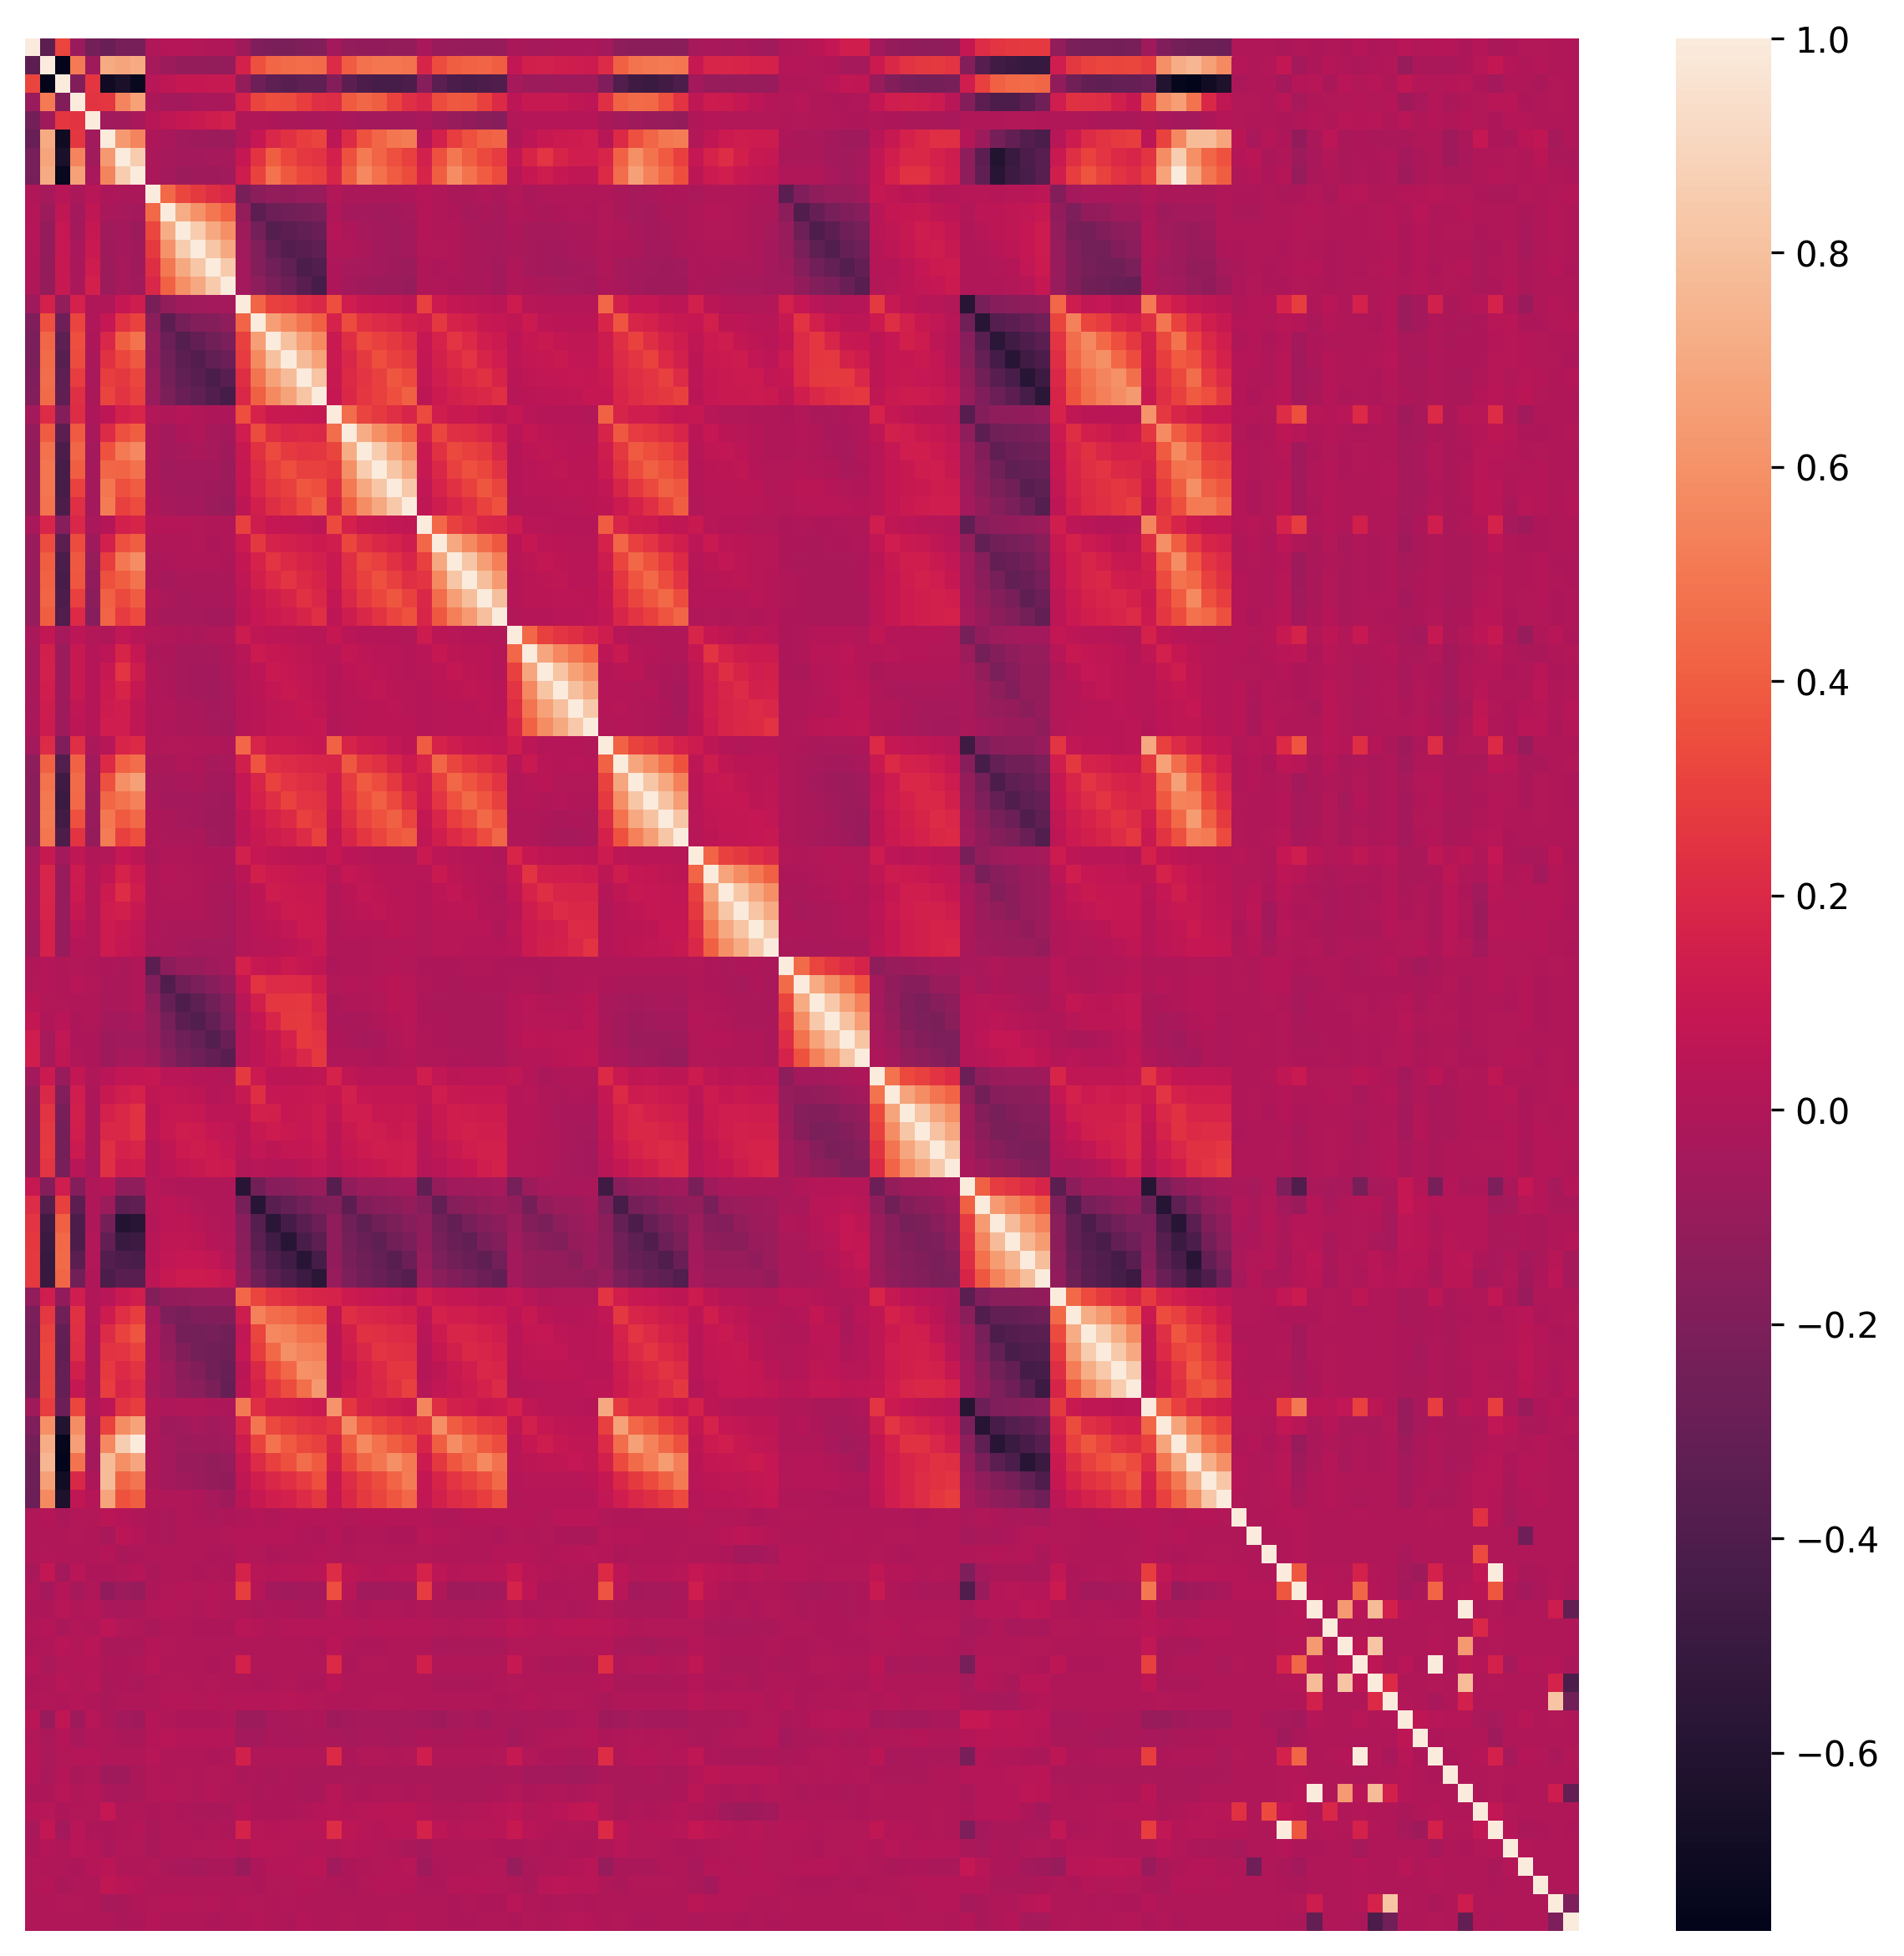

In [48]:
data, holdout = read_in_data(window=10)

X, y = split_features_target(data)

heatmap(X)

In [29]:
data, holdout = read_in_data(window=10, threshold=0.001)

X_train, y_train = split_features_target(data)
X_test, y_test = split_features_target(holdout)

In [30]:
y_train.value_counts()


0    2677
1    2309
Name: label, dtype: int64

In [32]:
X_train.shape

(4986, 129)

# Feature Ranking

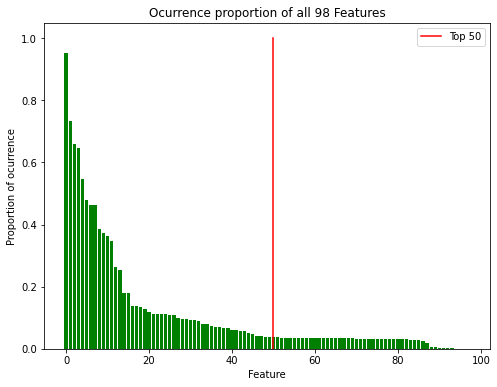

In [21]:
features = pd.read_csv('feature_counts_10d.csv', header=None, names=['ticker', 'count'])
features['proportion'] = features['count']/10000

x = list(features.ticker)
xpos = [i for i, _ in enumerate(x)]
prop = list(features.proportion)

plt.figure(figsize=(8,6))
plt.bar(xpos, prop, color='green')
plt.plot([50 for i in range(1000)], np.linspace(0,1,1000), color='red', label='Top 50')
plt.xlabel('Feature')
plt.ylabel('Proportion of ocurrence')
plt.title('Ocurrence proportion of all 98 Features')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Ocurrence proportion of all 98 Features')

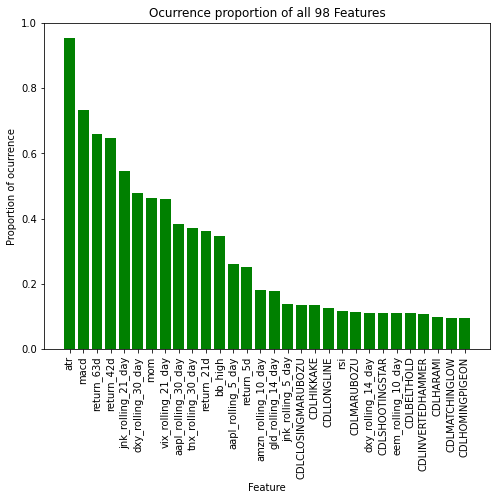

In [40]:
features = pd.read_csv('feature_counts_10d.csv', header=None, names=['ticker', 'count'])
features['proportion'] = features['count']/10000
features = features[:30]

x = list(features.ticker)
xpos = [i for i, _ in enumerate(x)]
prop = list(features.proportion)

plt.figure(figsize=(8,6))
plt.bar(xpos, prop, color='green')
plt.xticks(xpos, x, rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Proportion of ocurrence')
plt.title('Ocurrence proportion of top 30 Features')

Text(0.5, 1.0, 'Ocurrence proportion of top 10 Features')

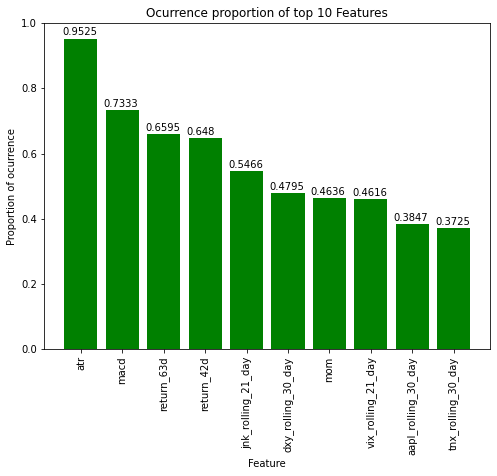

In [52]:
features = pd.read_csv('feature_counts_10d.csv', header=None, names=['ticker', 'count'])
features['proportion'] = features['count']/10000
features = features[:10]

x = list(features.ticker)
xpos = [i for i, _ in enumerate(x)]
prop = list(features.proportion)

plt.figure(figsize=(8,6))
plt.bar(xpos, prop, color='green')
plt.xticks(xpos, x, rotation='vertical')

for i in range(len(xpos)):
    plt.annotate(prop[i], (xpos[i]-0.45, prop[i]+0.01))
plt.xlabel('Feature')
plt.ylabel('Proportion of ocurrence')
plt.title('Ocurrence proportion of top 10 Features')

# Baseline Model

In [35]:
data, holdout = read_in_data(window=10, threshold=0.001)
data = data[-1000:]

features = pd.read_csv('feature_counts_10d.csv', header=None, index_col=0)
feature_list = list(features.index)[:10]

X_train, y_train = split_features_target(data)
X_test, y_test = split_features_target(holdout)

X_train = X_train[feature_list]
X_test = X_test[feature_list]

baseline_tree = DecisionTreeClassifier().fit(X_train, y_train)

y_pred = baseline_tree.predict_proba(X_test)[:,1]

auc = roc_auc_score(y_test, y_pred)

print(auc)
print(data)

0.5278391673201682
              volume        rsi   bb_high    bb_low       atr      macd  \
date                                                                      
2015-01-12  34129800  44.714245  0.041478  0.018714  5.909265 -0.239065   
2015-01-13  56162300  44.600221  0.041793  0.019222  5.993705 -0.299306   
2015-01-14  51354200  42.426189  0.046971  0.014282  5.921294 -0.385555   
2015-01-15  51005400  37.785961  0.058638  0.001326  5.899933 -0.548069   
2015-01-16  35362200  43.707778  0.048437  0.013718  5.923328 -0.580430   
...              ...        ...       ...       ...       ...       ...   
2018-12-24  56163300  25.817716  0.166905 -0.023409  5.288293 -4.794291   
2018-12-26  98982100  40.833343  0.122561  0.042409  5.679280 -4.676911   
2018-12-27  85824300  41.670595  0.118756  0.050957  5.709331 -4.485148   
2018-12-28  77856600  41.584682  0.114957  0.054098  5.614143 -4.290098   
2018-12-31  53015300  43.604141  0.103592  0.063441  5.487828 -3.986720   

     

Text(0.5, 1.0, 'ROC Curve of Baseline Decision Tree')

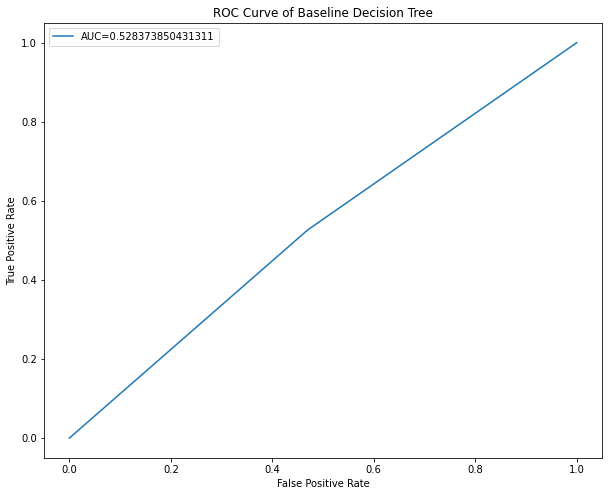

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)


plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label=f'AUC={auc}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve of Baseline Decision Tree')

In [5]:
from sklearn.svm import SVC

In [ ]:
data, holdout = read_in_data(window=10, threshold=0.001)
data = data[-1000:]

features = pd.read_csv('feature_counts_10d.csv', header=None, index_col=0)
feature_list = list(features.index)[:5]

X_train, y_train = split_features_target(data)
X_test, y_test = split_features_target(holdout)

final_SVM = SVC(C=0.1, kernel='linear', probability=True).fit(X_train, y_train)

y_pred = final_SVM.predict_proba(X_test)[:,1]

auc = roc_auc_score(y_test, y_pred)
auc